## Convolutional Neural Network

Michel Kana

<hr style="height:2pt">

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras import backend as K 
K.set_image_dim_ordering('tf')

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold 
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

from astropy.table import Table

import glob
import h5py    

from PIL import Image
from scipy.misc import toimage
import skimage
from skimage import data, io
from skimage.transform import rescale, resize, downscale_local_mean

from matplotlib import pyplot
import matplotlib.pylab as plt 
from IPython.display import Image
%matplotlib inline

# if you do not have skimage then you may install is by running $ conda install -c anaconda scikit-image

Using TensorFlow backend.


In [297]:
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from keras.datasets import cifar10
from sklearn.preprocessing import StandardScaler
from keras import regularizers
from keras.layers import BatchNormalization
from keras.optimizers import rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from random import randint
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
from keras.models import clone_model
import seaborn as sns
from vis.visualization import visualize_cam

In [263]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

**Overview**

In this project, we will explore Convolutional Neural Networks (CNNs).  We'll explore the mechanics of convolutional operations, will build a CNN to classify CIFAR-10 images, and will build a CNN for detecting gravitational waves from the LIGO observatory. Specifically, we will use images generated from the raw time series data to train a model that can distinguish between real gravitational events and noise. 

## Part 1: Convolutional Neural Network Basics


In convolutional neural networks, a convolution is a multiplicative operation on a local region of values. Convolutional layers have shown themselves to have been very useful in image classification, as they allows the network to retain local spatial information for feature extraction.

**1.1 Calculate Convolutions.**

*For the following 2D matrix:*

$$
\left( \begin{array}{cccc}
2 & 3 & 2 & 4 \\
3 & 1 & 2 & 2 \\
4 & 1 & 0 & 1 \\
7 & 2 & 1 & 3
\end{array} \right)
$$

*we will use the following 2x2 kernel to perform a 2D convolution operation.*

$$
\left( \begin{array}{cc}
2 & 1 \\
1 & 3 
\end{array} \right)
$$

*Compute this operation by hand assuming a vertical and horizontal stride of 1 as well as a) valid, b) same, and c) full border modes.  For each mode, indicate the shape of the the resulting (post-convolution) matrix and compare it to the shape of the original matrix.*

a) "VALID": Filter window stays at valid position inside input map, so output size shrinks by filter_size - 1 = (3x3). No padding occurs.

$$
\left( \begin{array}{cccc}
2*2+1*3+1*3+3*1 & 2*3+1*2+1*1+3*2 & 2*2+1*4+1*2+3*2 \\
2*3+1*1+1*4+3*1 & 2*1+1*2+1*1+3*0 & 2*2+1*2+1*0+3*1 \\
2*4+1*1+1*7+3*2 & 2*1+1*0+1*2+3*1 & 2*0+1*1+1*1+3*3
\end{array} \right)
$$

$$
\left( \begin{array}{cccc}
13 & 15 & 16 \\
14 & 5 & 9 \\
22 & 7 & 11
\end{array} \right)
$$

b) "SAME": output size (4x4) is the same as input size. This requires the filter window to slip outside input map, hence the need to pad top and left.

$$
\left( \begin{array}{cccc}
0 & 0 & 0 & 0 & 0 \\
0 & 2 & 3 & 2 & 4 \\
0 & 3 & 1 & 2 & 2 \\
0 & 4 & 1 & 0 & 1 \\
0 & 7 & 2 & 1 & 3
\end{array} \right)
$$

$$
\left( \begin{array}{cccc}
2*0+0*1+1*0+3*2 & 2*0+1*0+1*2+3*3 & 2*0+1*0+1*3+3*2 & 2*0+1*0+1*2+3*4 \\
2*0+1*2+1*0+3*3 & 2*2+1*3+1*3+3*1 & 2*3+1*2+1*1+3*2 & 2*2+1*4+1*2+3*2 \\
2*0+3*1+1*0+4*3 & 2*3+1*1+1*4+3*1 & 2*1+2*1+1*1+3*0 & 2*2+1*2+1*0+3*2 \\
2*0+1*4+1*0+3*7 & 2*4+1*1+1*7+3*2 & 2*1+1*0+1*2+3*1 & 2*0+1*1+1*1+3*3 
\end{array} \right)
$$

$$
\left( \begin{array}{cccc}
6 & 11 & 9 & 14 \\
11 & 13 & 15 & 16 \\
15 & 14 & 5 & 12 \\
25 & 22 & 7 & 11
\end{array} \right)
$$



c) "FULL BORDER": output size (5x5)

$$
\left( \begin{array}{cccc}
0 & 0 & 0 & 0 & 0 & 0\\
0 & 2 & 3 & 2 & 4 & 0\\
0 & 3 & 1 & 2 & 2 & 0\\
0 & 4 & 1 & 0 & 1 & 0\\
0 & 7 & 2 & 1 & 3 & 0\\
0 & 0 & 0 & 0 & 0 & 0
\end{array} \right)
$$

$$
\left( \begin{array}{cccc}
2*0+1*0+1*0+3*2 & 2*0+1*0+1*2+3*3 & 2*0+1*0+1*3+2*3 & 2*0+1*0+1*2+3*4 & 2*0+1*0+1*4+3*0 \\
2*0+1*2+1*0+3*3 & 2*2+1*3+1*3+3*1 & 2*3+1*2+1*1+2*2 & 2*2+1*4+1*2+3*2 & 2*4+1*0+1*2+3*0 \\
2*0+1*3+1*0+3*4 & 2*3+1*1+1*4+3*1 & 2*1+1*2+1*1+2*0 & 2*2+1*2+1*0+3*1 & 2*2+1*0+1*1+3*0 \\
2*0+1*4+1*0+3*7 & 2*4+1*1+1*7+3*2 & 2*1+1*0+1*2+2*1 & 2*0+1*1+1*1+3*3 & 2*1+1*0+1*3+3*0 \\
2*0+1*7+1*0+3*0 & 2*7+1*2+1*0+3*0 & 2*2+1*1+1*0+2*0 & 2*1+1*3+1*0+3*0 & 2*3+1*0+1*0+3*0 
\end{array} \right)
$$

$$
\left( \begin{array}{cccc}
6 & 11 & 9 & 14 & 4 \\
11 & 13 & 13 & 16 & 10 \\
15 & 14 & 5 & 9 & 5 \\
25 & 22 & 6 & 11 & 5 \\
7 & 16 & 5 & 5 & 6 
\end{array} \right)
$$

**1.2 Understanding Pooling Operations.**

Pooling operations are often used in convolutional neural networks to reduce the dimensionality of the feature maps as well as overall network complexity. Two main types of pooling are used: AveragePooling and MaxPooling.

**1.2.1.** Using the matrix below, write the output of the AveragePooling and MaxPooling operations with pool size 2x2 and stride  2x2.

$$
\left( \begin{array}{cccc}
1 & 2 & 2 & 4 \\
3 & 1 & 2 & 1 \\
4 & 1 & 0 & 2 \\
5 & 2 & 2 & 1
\end{array} \right)
$$

AveragePooling
$$
\left( \begin{array}{cccc}
2 & 2 \\
3 & 1
\end{array} \right)
$$


MaxPooling
$$
\left( \begin{array}{cccc}
3 & 4 \\
5 & 2
\end{array} \right)
$$

**1.2.2. Repeat 1.2.1 with a stride of size 1.**


AveragePooling
$$
\left( \begin{array}{cccc}
2 & 2 & 2 \\
2 & 1 & 1 \\
3 & 1 & 1
\end{array} \right)
$$


MaxPooling
$$
\left( \begin{array}{cccc}
3 & 2 & 4 \\
3 & 2 & 2 \\
5 & 2 & 2
\end{array} \right)
$$

**Consider the following image of a dog:**

![dog](data/Kintamani_dog_white_gs.jpeg)


**1.3.1. Load the image as a 2D Numpy array into the variable dog_image_data. Appropriately normalize the image data so that values within dog_image_data fall within [-0.5, 0.5].**

In [5]:
dog_image_data = plt.imread('data/Kintamani_dog_white_gs.jpeg')
dog_image_data.shape

(600, 800, 3)

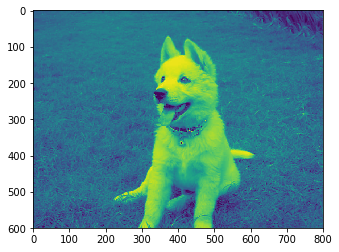

In [7]:
plt.imshow(dog_image_data[:,:,1])

In [12]:
np.max(dog_image_data), np.min(dog_image_data)

(255, 0)

In [21]:
dog_image_data_norm = dog_image_data.astype('float32')/255-.5

In [22]:
np.max(dog_image_data_norm), np.min(dog_image_data_norm)

(0.5, -0.5)

**1.3.2. Choose three 3x3 convolution kernels (you can look up kernels for edge detection, normalized box blurring, and sharpening, see https://en.wikipedia.org/wiki/Kernel_(image_processing) for example), and apply each of these kernels to the image with same border mode (you may want to implement your own convolution function or try using scipy.signal.convolve2d).**

In [36]:
kernel_edge = [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]
kernel_sharpen = [[0, -1, 0], [-1, 5, -1], [0, -1, 0]]
kernel_blur = [[1/9, 1/9, 1/9], [1/9, 1/9, 1/9], [1/9, 1/9, 1/9]]

In [49]:
dog_image_data_norm_edge = convolve2d(dog_image_data_norm[:,:, 1], kernel_edge, mode="same")

In [50]:
dog_image_data_norm_sharpen = convolve2d(dog_image_data_norm[:,:, 1], kernel_sharpen, mode="same")

In [51]:
dog_image_data_norm_blur = convolve2d(dog_image_data_norm[:,:, 1], kernel_blur, mode="same")

**1.3.3. In the resulting convolved image data matrices, set all pixel values less than zero to zero (using np.clip()). In other words:**

In [52]:
dog_image_data_norm_edge_clip = np.clip(dog_image_data_norm_edge, 0, .5)

In [53]:
dog_image_data_norm_sharpen_clip = np.clip(dog_image_data_norm_sharpen, 0, .5)

In [54]:
dog_image_data_norm_blur_clip = np.clip(dog_image_data_norm_blur, 0, .5)

**1.3.4. Show plots of the resulting images.**

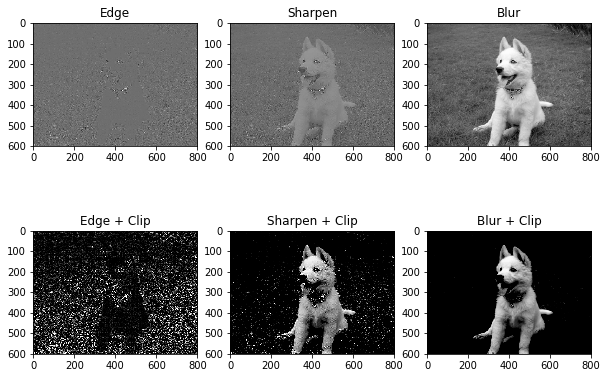

In [78]:
fig, ax = plt.subplots(2,3, figsize=(10,7))
ax[0][0].imshow(dog_image_data_norm_edge, cmap='gray')
ax[0][0].set_title('Edge')
ax[0][1].imshow(dog_image_data_norm_sharpen, cmap='gray')
ax[0][1].set_title('Sharpen')
ax[0][2].imshow(dog_image_data_norm_blur, cmap='gray')
ax[0][2].set_title('Blur')
ax[1][0].imshow(dog_image_data_norm_edge_clip, cmap='gray')
ax[1][0].set_title('Edge + Clip')
ax[1][1].imshow(dog_image_data_norm_sharpen_clip, cmap='gray')
ax[1][1].set_title('Sharpen + Clip')
ax[1][2].imshow(dog_image_data_norm_blur_clip, cmap='gray')
ax[1][2].set_title('Blur + Clip');

**1.3.5.** Take a moment to examine the convolved images. You should see that certain features in the puppy are accentuated, while others are de-emphasized. What might be the effect of performing additional convolution operations on these filtered images and how might they relate to additional layers in a neural network?

We find that the first concolution layer will train itself to recognize very basic things like edges. The next convolution layer will train itself to recognize collections of edges which build the shape of the dog. Adding a next convolution layer will train itself to recognize collections of shapes like ears, eyes, legs, tails, faces. Adding more layers will learn even higher-order features like objects (the whole dog). Generalizing is achieved in a better way by adding more convolution layers because they learn all the intermediate features between the raw input and the high-level classification.

## Part 2: Building a Basic CNN Model 

In this part, we will use Keras to create a convolutional neural network for predicting the type of object shown in images from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset, which contains 50,000 32x32 training images and 10,000 test images of the same size, with a total of 10 classes.


**2.1 Loading CIFAR-1O and Constructing the Model.**

*Load CIFAR-10 and use a combination of the [following layers](https://keras.io/layers/convolutional/): Conv2D, MaxPooling2D, Dense, Dropout and Flatten Layers (not necessarily in this order) to build our model.
We may use an existing architecture like AlexNet or VGG16*

*Convolutional neural networks are very computationally intensive. It is recommended to train the model on a system using GPUs. On CPUs, this training can take up to several hours. On GPUs, it can be done within minutes.*

*We can approach the problems in this question by first creating a model assigning 32 filters to each Conv2D layer recreate the model with 64 filters/layer, 128, etc.  For each generated model, keep track of the total number of parameters.*

In [202]:
(xtrain, ytrain), (xtest, ytest) = cifar10.load_data()

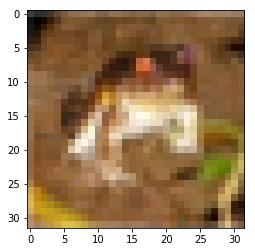

In [203]:
plt.imshow(xtrain[0])

In [242]:
x_train = xtrain.astype('float32')
x_test = xtest.astype('float32')
x_train  /= 255
x_test /= 255

In [243]:
x_train.shape, ytrain.shape

((50000, 32, 32, 3), (50000, 1))

In [244]:
np.unique(ytrain)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [245]:
nb_classes = 10
y_train = np_utils.to_categorical(ytrain, nb_classes)
y_test = np_utils.to_categorical(ytest, nb_classes)

In [246]:
y_train.shape

(50000, 10)

The following function creates a flexible CNN architecture:

- Conv2D: convolution layer with a variable number of filters and filter size. L2 regularization is used to avoid overfitting, as recommended in the AlexNet paper. This means that large weights are penalized by a factor slightly less than 1 prior to each update.
- BatchNormalization: maintains the mean activation in mini-batch close to 0 and the activation standard deviation close to 1 in order to solve internal covariate shift. This allows our network to converge faster.
- MaxPooling2D: downsamples the feature maps in order to identify the most important features.
- Dropout: by randomly ignoring some nodes, we force the remaining nodes to learn other features. This improves the generalization capability of our network.

We repeat the above block of layers several times.

In [247]:
def create_cnn(input_shape=x_train.shape[1:], nb_classes=nb_classes, nb_blocks=3, nb_filters=32, filter_size=(3,3), 
               pool_size=(2,2), weight_decay=1e-4, padding='same', dropout=.2, output_activation='softmax'):

    model = Sequential()

    for i in range(nb_blocks):
        if i==0:
            model.add(Conv2D(nb_filters, filter_size, activation='relu', padding=padding, kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
        else:
            model.add(Conv2D(nb_filters, filter_size, activation='relu', padding=padding, kernel_regularizer=regularizers.l2(weight_decay)))        
        model.add(BatchNormalization())
        model.add(Conv2D(nb_filters, filter_size, activation='relu', padding=padding, kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=pool_size))
        model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(nb_classes, activation=output_activation))

    return model

Below we see the effect of the number of filters on the model complexity. The relationship is quadratic. The more filter we add, the more features the model can learn, but the more it can overfit the training data. High complexity reduces bias but results in a less generalized model. Regularization is mandatory in this case. Optimization should also be considered while facing longer training time.

In [248]:
nb_filters = [32, 64, 128, 256, 512, 1028]
nb_parameters = []
for n in nb_filters:
    cnn = create_cnn(nb_filters=n)
    nb_parameters.append(cnn.count_params())
    

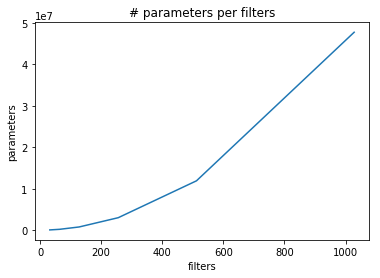

In [249]:
plt.plot(nb_filters, nb_parameters)
plt.title('# parameters per filters')
plt.xlabel('filters')
plt.ylabel('parameters');

**2.2.1. Choose a model from 2.1 and train it.**

We prepare the image generator for data augmentation by rotating, flipping and shifting images. By increasing the number of training points, we reduce the chance to overfit.

In [250]:
cifar_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
cifar_gen.fit(x_train)

In [251]:
cnn = create_cnn(nb_filters=32)

In [252]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_61 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_62 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 16, 16, 32)        9248      
__________

We choose RMSprop as adaptative learning rate optimizer. SGD did also very well, with momentum. Categorical crossetropy is used as loss function since our output has 10 classes. Accuracy is used as metric since the data is balanced.

In [253]:
opt_rms = rmsprop(lr=0.001, decay=1e-6)
cnn.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

In [254]:
y_test.shape, y_train.shape

((10000, 10), (50000, 10))

In [255]:
batch_size = 64
epochs = 100
steps = x_train.shape[0] // batch_size

cnn_history = cnn.fit_generator(cifar_gen.flow(x_train, y_train, batch_size=batch_size),
                                  steps_per_epoch=steps, 
                                  epochs=epochs,
                                  verbose=1,
                                  validation_data=(x_test,y_test))

Epoch 1/100
781/781 [==============================] - 29s 38ms/step - loss: 1.7060 - acc: 0.4141 - val_loss: 1.3775 - val_acc: 0.5297
Epoch 2/100
781/781 [==============================] - 25s 32ms/step - loss: 1.2319 - acc: 0.5689 - val_loss: 1.0731 - val_acc: 0.6307
Epoch 3/100
781/781 [==============================] - 25s 33ms/step - loss: 1.0624 - acc: 0.6322 - val_loss: 1.0065 - val_acc: 0.6601
Epoch 4/100
781/781 [==============================] - 25s 32ms/step - loss: 0.9743 - acc: 0.6633 - val_loss: 0.9584 - val_acc: 0.6790
Epoch 5/100
781/781 [==============================] - 25s 32ms/step - loss: 0.9207 - acc: 0.6867 - val_loss: 0.8808 - val_acc: 0.7101
Epoch 6/100
781/781 [==============================] - 25s 32ms/step - loss: 0.8869 - acc: 0.6991 - val_loss: 1.0836 - val_acc: 0.6437
Epoch 7/100
781/781 [==============================] - 25s 32ms/step - loss: 0.8548 - acc: 0.7105 - val_loss: 0.8736 - val_acc: 0.7119
Epoch 8/100
781/781 [==============================] - 

In [264]:
cnn_json = cnn.to_json()
with open('cifar10_cnn.json', 'w') as json_file:
    json_file.write(cnn_json)
cnn.save_weights('cifar10_cnn.h5') 

**2.2.2. Plot the loss and validation accuracy for your chosen architecture.**

In [256]:
def plot_cnn(cnn_history):
    fig, ax = plt.subplots(1, 2, figsize=(20,6))
    ax[0].plot(np.sqrt(cnn_history.history['acc']), 'r', label='train_acc')
    ax[0].plot(np.sqrt(cnn_history.history['val_acc']), 'b' ,label='val_acc')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].tick_params()
    ax[0].set_title('CNN training performance');
    ax[1].plot(np.sqrt(cnn_history.history['loss']), 'r', label='train_loss')
    ax[1].plot(np.sqrt(cnn_history.history['val_loss']), 'b' ,label='val_loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].tick_params()
    ax[1].set_title('CNN training performance');
    print('Average Accuracy: training {0:0.2%}, validation {1:0.2%}'.format(np.mean(cnn_history.history['acc']), np.mean(cnn_history.history['val_acc'])))

Average Accuracy: training 78.15%, validation 77.85%


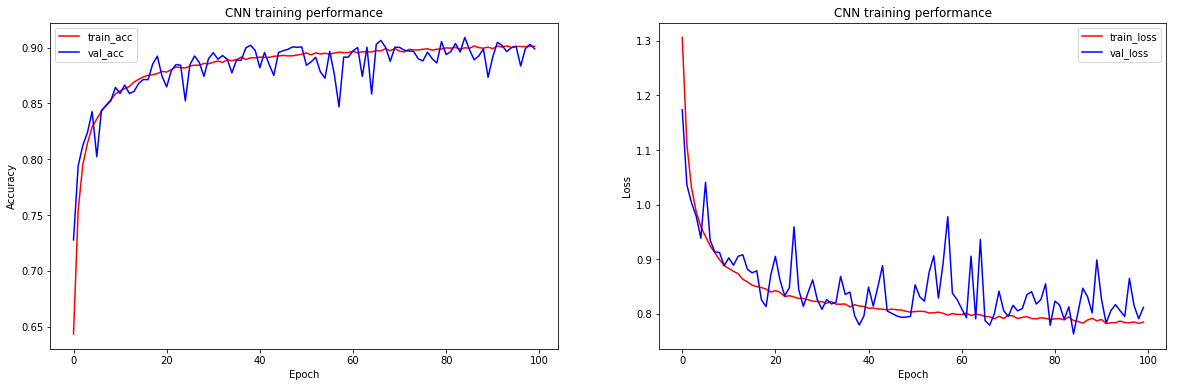

In [257]:
plot_cnn(cnn_history)

**2.3.1. For a given input image, use your model and extract 9 feature maps from an intermediate convolutional layer of your choice and plot the images in a 3x3 grid. Make sure to plot (and clearly label) your original input image as well.**

In [258]:
labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [259]:
print(cnn.layers[0].output.shape)

(?, 32, 32, 32)


The following function picks a random image or a given input image from CIFAR-10 dataset, and it plots the feature maps of convolution and max pooling layers. The layer IDs can be entered as input. Each image shows a heatmap of the features learned by the corresponding layer. 

In [289]:
def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

def plot_features_map(img_idx=None, layer_idx=[0, 2, 4, 6, 8, 10, 12, 16], x_test=x_test, ytest=ytest, cnn=cnn):
    if img_idx == None:
        img_idx = randint(0, ytest.shape[0])
    input_image = x_test[img_idx]
    fig, ax = plt.subplots(3,3,figsize=(10,10))
    ax[0][0].imshow(input_image)
    ax[0][0].set_title('original img id {} - {}'.format(img_idx, labels[ytest[img_idx][0]]))
    for i, l in enumerate(layer_idx):
        feature_map = get_feature_maps(cnn, l, input_image)
        ax[(i+1)//3][(i+1)%3].imshow(feature_map[:,:,0])
        ax[(i+1)//3][(i+1)%3].set_title('layer {} - {}'.format(l, cnn.layers[l].get_config()['name']))
    return img_idx

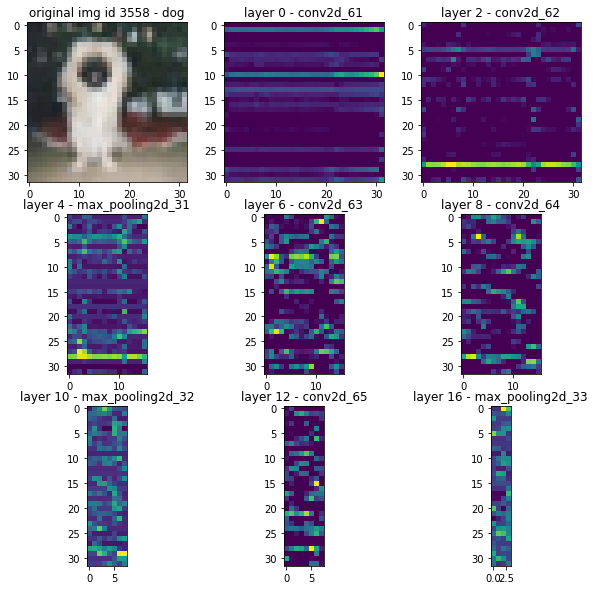

In [290]:
img_idx = plot_features_map()

**2.3.2. For the same input image generate and plot a saliency map to show the pixels in the image most pertinent to classification. While you're welcome to generate the saliency map by hand, we highly recommend that you install and use keras-vis and let it handle the generation.**


The saliency map is built using gradiends of the output over the input. This highlights the areas of the images which were relevant for the classification. For example we can see below that water plays a significant role when recognizing the boat. Maybe the model won't be so successful if it is given a boat outside water in a construction site.

In [160]:
cnn_saliency = clone_model(cnn)
cnn_saliency.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
cnn_saliency.set_weights(cnn.get_weights())

In [161]:
cnn_saliency.layers[-1].activation = activations.linear 
cnn_saliency = utils.apply_modifications(cnn_saliency)

In [193]:
def plot_saliency(img_idx=None):
    img_idx = plot_features_map(img_idx)
    grads = visualize_saliency(cnn_saliency, -1, filter_indices=ytest[img_idx][0], 
                               seed_input=x_test[img_idx], backprop_modifier=None,
                               grad_modifier="absolute")
    predicted_label = labels[np.argmax(cnn.predict(x_test[img_idx].reshape(1,32,32,3)),1)[0]]
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(x_test[img_idx])
    ax[0].set_title('original img id {} - {}'.format(img_idx, labels[ytest[img_idx][0]]))
    ax[1].imshow(grads, cmap='jet')
    ax[1].set_title('saliency - predicted {}'.format(predicted_label))

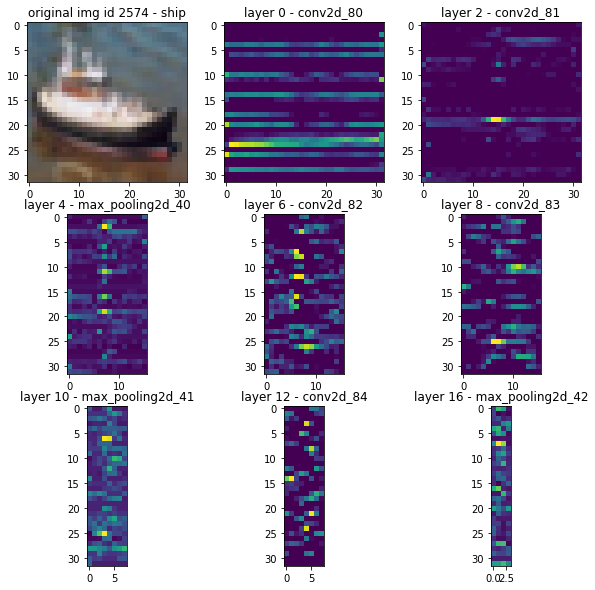

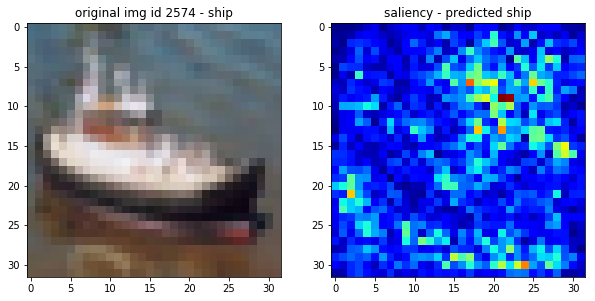

In [195]:
plot_saliency()

## Gravitational Waves
Gravitational waves are a prediction of Einstein's Genaral Relativity theory.  They are ripples on the space-time, propagating at the speed of light, caused by the merging of two massive obejcts (e. g. black holes, white dwarves, pulsars) .

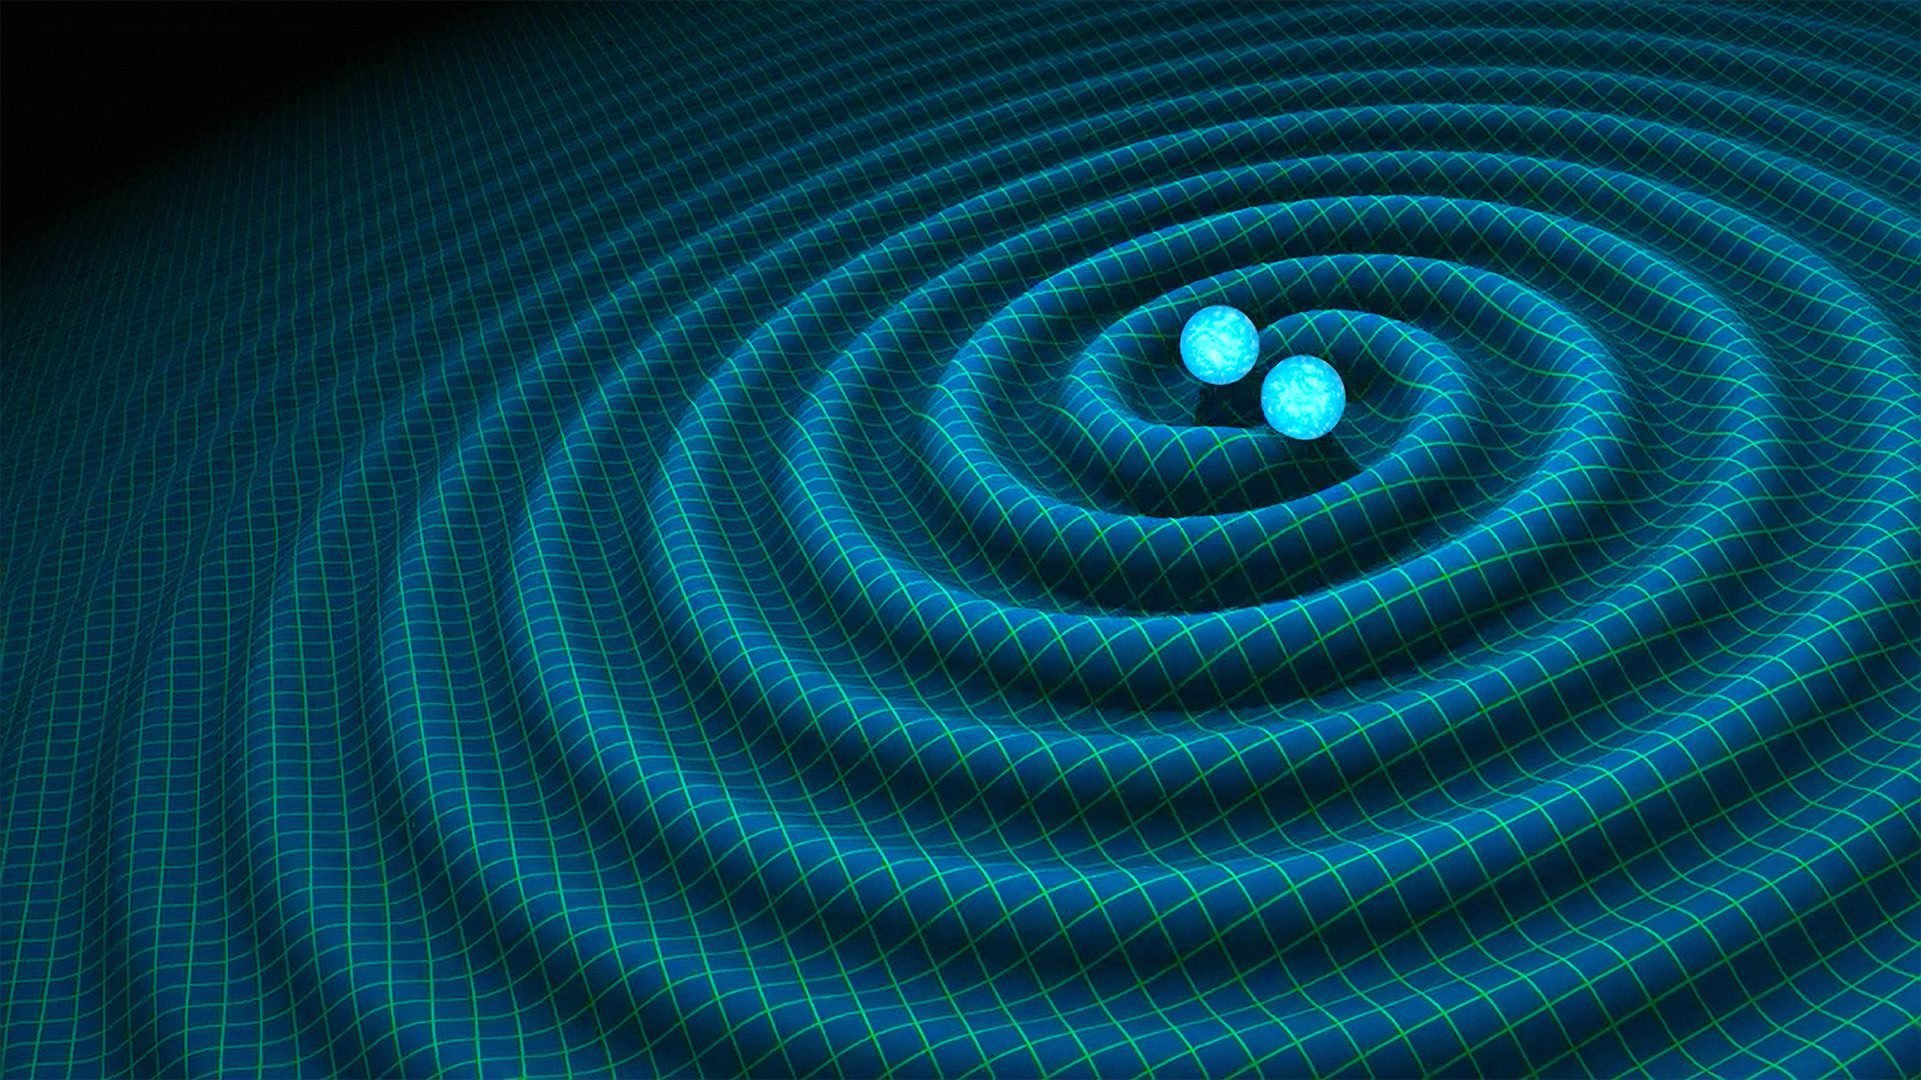

In [196]:
Image('data/gravitational-waves-generated-by-binary-neutron-stars.jpg',width=1000)

### LIGO observatory
The Laser Interferometer Gravitational-Wave Observatory (LIGO) was designed for the direct detection of gravitational waves. It is made up of two identical and widely separated interferometers that look like this: 

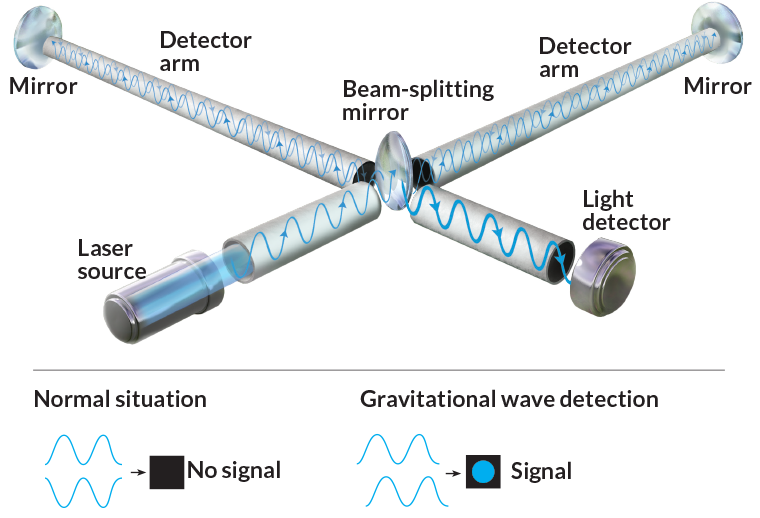

In [197]:
Image('data/100317_nobel-physics_inline_ligo-diagram.png', width=1000)

Image credit: NICOLLE RAGER FULLER

### Nobel Price Physics:
Rainer Weiss, Barry Barish, and Kip Thorne won the 2017 Nobel Prize in Physics for their work on GWs

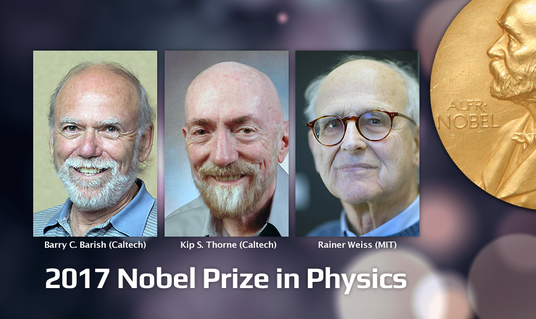

In [16]:
Image('data/Nobel-barish-thorne-weiss_edit.png', width=600)

Image credit: LIGO/Caltech/MIT

### What do Gravitation Wave signals look like?

This is the data from the first GW detection. The first row shows the time series observed, the second the expected signal from simulations, and the third the intensity of each frequency in time from the observed data. The left column corresponds to the Hanford detector in Washington, and the right column to the Livingston detector in Louisiana.  The GW was seen by both detectors, as expected for a real event.

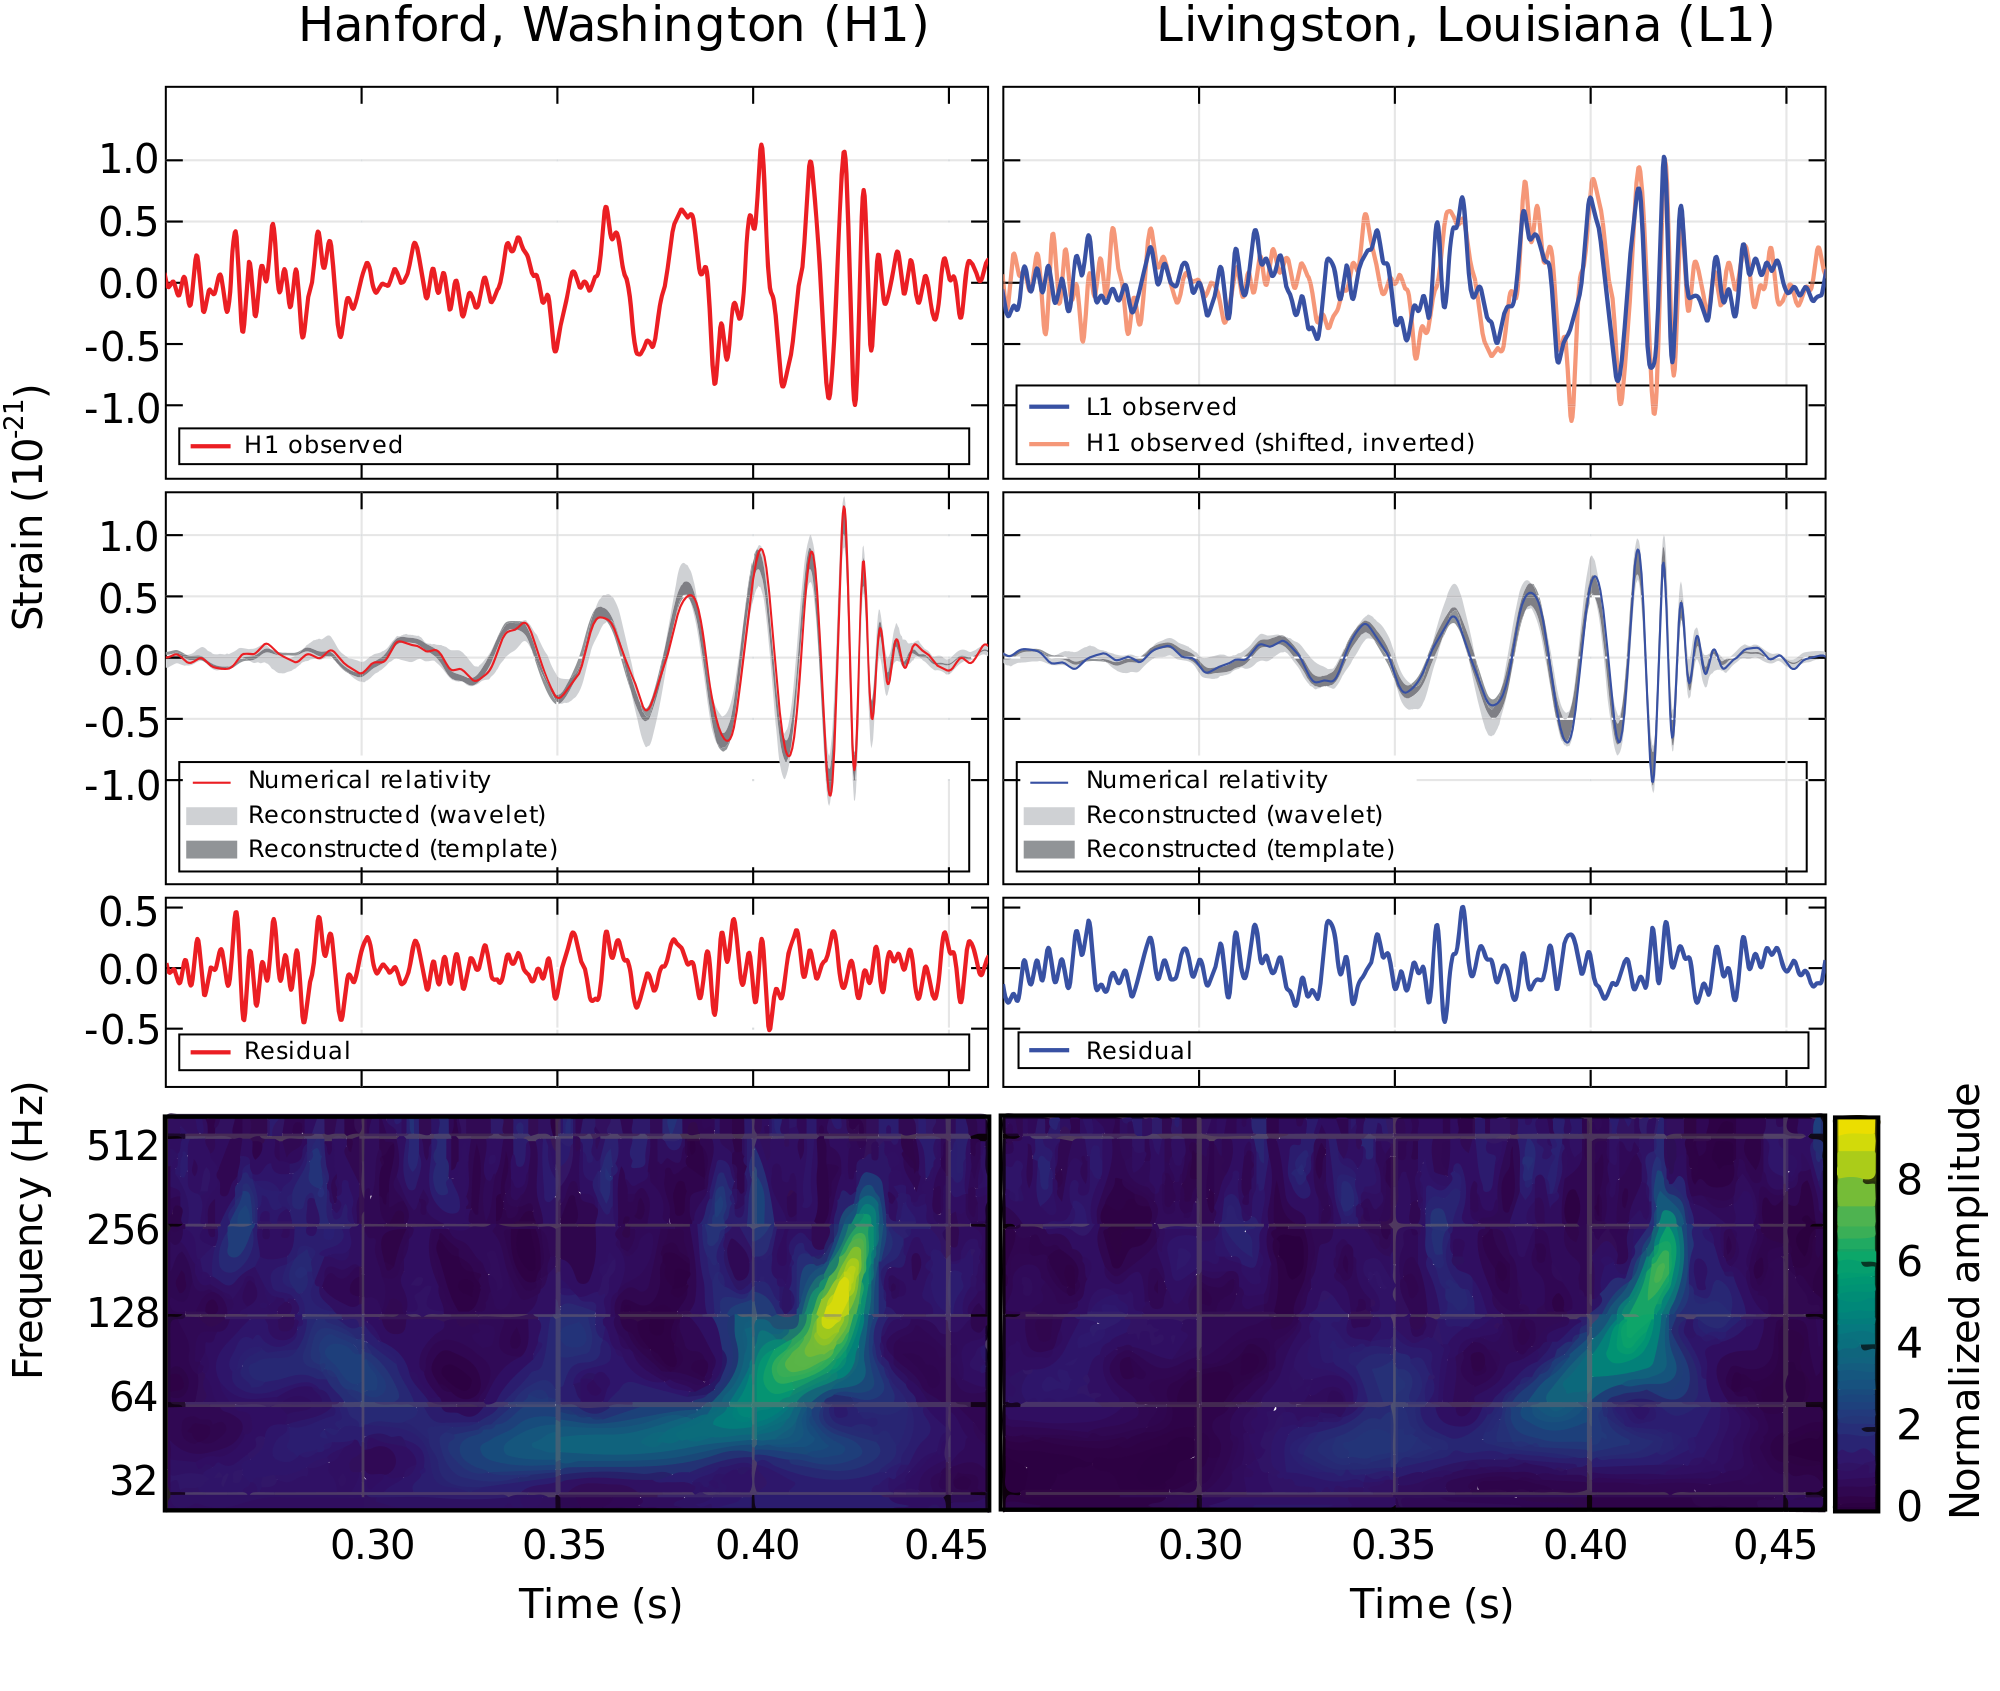

In [17]:
Image('data/LIGO_measurement_of_gravitational_waves.svg.png', width=1100)

Phys. Rev. Lett. 116, 061102 (2016) (https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102)

## Part 3: Building a CNN for Classification of Gravity Wave Events

We have built, trained, evaluated and inspected neural networks on a few common datasets such as MNIST or CIFAR10. Now it's time to try a real-world dataset. We want to consider the problem of classifying images as either gravitational waves or non-detection events using images from two detectors, one from the LIGO Hanford and LIGO Livingston.

It is helpful to gain some domain knowledge on gravitational wave detection. Browse through the information at the following links:



- https://www.ligo.caltech.edu/page/gravitational-waves 
- https://www.zooniverse.org/projects/zooniverse/gravity-spy 


**3.1 Learn about Gravitational Wave Detection. Load and Clean the Data.**



Gravitational waves are not part of the electromagnetic spectrum. They are created by massive objects such as black holes, neutron stars, moving close to each other or merging with very high acceleration. 

LIGO's interferometers are set up so that, as long as the arms don't change length (4 km physically, 1120 km effectively) while the laser beams (750 kilowatts) are traveling, nothing reaches the photodetector. Otherwise, something (gravitational waves) happened to change the distance and the interference pattern can be used to calculate precisely how much change in length occurred, ca. 1e-19 m. This is because gravitational waves cause space itself to stretch in one direction and squeeze in a perpendicular direction at the same time.

LIGO generates terabytes of data every day. Currently the data archive at Caltech holds over 4.5 Petabytes of data. It is expected to grow at a rate of 800 terabytes per year.

In [266]:
GW = np.load('data/GW_aug.npy')

In [267]:
ND = np.load('data/ND_aug.npy')

In [268]:
GW.shape, ND.shape

((1568, 39, 100, 2), (1216, 39, 100, 2))

We have 1568 gravitational events. Each event has 39 frequency components. Each frequency has 100 time components. Each time component represents the normalized power of the given frequency component at the given time, recorded at 2 locations (H1 and L1).

We have 1216 non-gravitational events.

**Data Exploration**

 Each event is recorded as two spectrograms, what is like a photograph or image of the signals recorded at H1 and L1.
 
 
 A spectrogram plots frequencies in Y-axis (axis=1) and time in X-axis (axis=2).

 A spectrogram also conveys the signal strength (axis=3) using the colors – brighter the color the higher the energy of the signal.

 A spectrogram explains how the signal strength is distributed in every frequency found in the signal.

The function below plots the H1 and L1 spectograms for a given event.

In [269]:
def plot_event(event=0, data=GW): 
    fig, ax = plt.subplots(1,2,figsize=(5,5))
    ax[0].imshow(data[event,:,:,0])
    ax[0].set_title('Event {} - H1'.format(event))
    ax[1].imshow(data[event,:,:,1])
    ax[1].set_title('Event {} - L1'.format(event));

As shown below gravitational waves are usually detected identically at both H1 and L1 locations. Few waves are more amplified at one location than at the other. If we consider the locations as channels for our spectogram images, the classifier should not have much issues dealing with such different signatures of the same event. In fact they can be complementary, like channels in a RGB image.

The code below plots 5 randomly chosen events, left at H1 and rigth at L1.

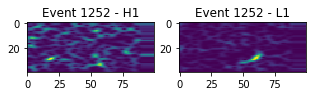

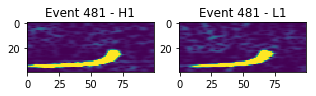

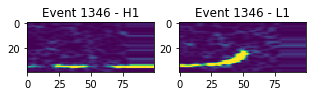

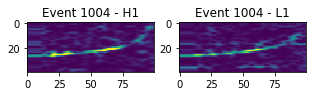

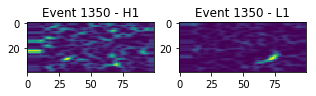

In [271]:
for e in range(5):
    e = randint(0, GW.shape[0])
    plot_event(e)

Non-gravitational waves (noise) are depicted below.

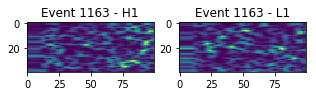

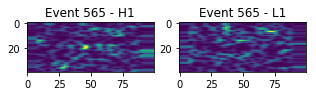

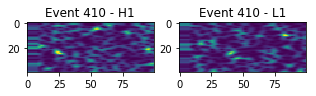

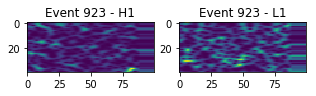

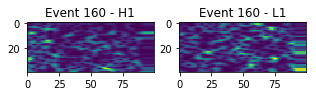

In [272]:
for e in range(5):
    e = randint(0, ND.shape[0])
    plot_event(e, data=ND)

**Outliers**

As seen below we probably have few outliers in the data. They relate to frequency components with power around 25.

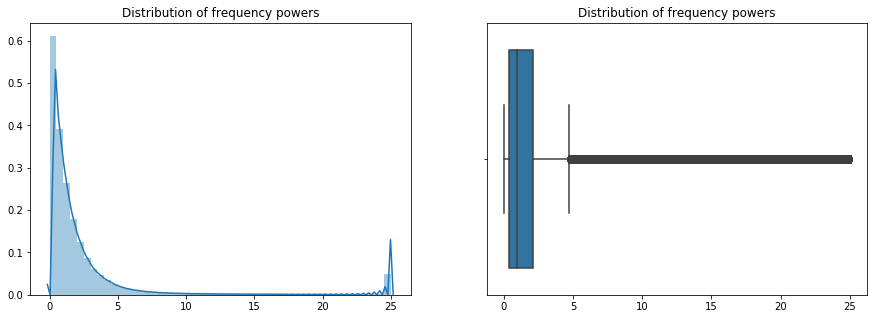

In [273]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.distplot(GW.flatten(), ax=ax[0])
ax[0].set_title('Distribution of frequency powers')
sns.boxplot(np.unique(GW), ax=ax[1])
ax[1].set_title('Distribution of frequency powers');

The function below helps us finding the outliers in the GW dataset. We did not handle the outliers since we did not find enough literature describing the units and shape of the data.

In [286]:
def clean_events(data=GW, threshold=20):
    data_clean = data.copy()
    outliers = np.where(data>threshold)
    outliers_idx = list(zip(outliers[0], outliers[1], outliers[2], outliers[3]))
    return outliers_idx

In [287]:
clean_events(GW)

[]

As shown below there is no obvious outliers in the non-gravitational events.

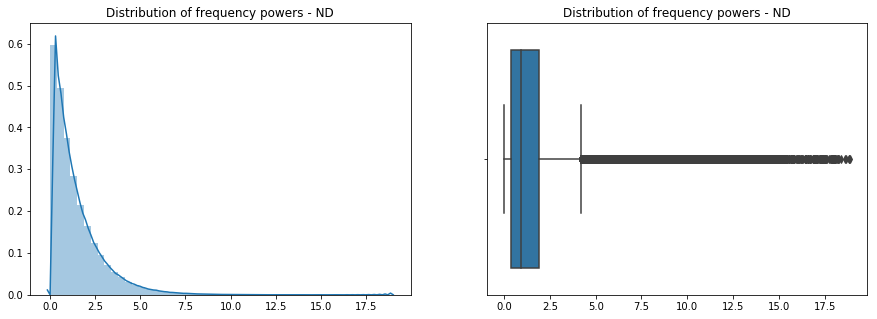

In [54]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.distplot(ND.flatten(), ax=ax[0])
ax[0].set_title('Distribution of frequency powers - ND')
sns.boxplot(np.unique(ND), ax=ax[1])
ax[1].set_title('Distribution of frequency powers - ND');

**3.1.1 Why do you think it is important to have data from both detectors? How might you combine observations from the two detectors into a single observation?**

To confirm the detection, a coincident signal of some kind would also have to be made, again, verifying that what the LIGO detector sensed at one location was not just some random noise in a single detector. Therefore having data from both detectors is cruxial. The event would be valid if at least one of the detectors recorded it. 

From LIGO website: "A system of single LIGO detector cannot confirm gravitational waves on its own. While an astronomical observatory can function and collect data just fine on its own (though some do not, by choice), gravitational wave detectors like LIGO's cannot operate solo. The only way to confirm a gravitational wave detection is by operating in unison with another detector. This ensures that local vibrations are not mistaken for gravitational waves. A single detector can, in principle, sense a gravitational wave, say from a supernova explosion. But to confirm the detection, a coincident electromagnetic signal of some kind would also have to be made, again, verifying that what the LIGO detector sensed was not just some random noise in a single detector."

We might combine both observations of the same event by adding them up, thus amplifying the frequency components detected on both locations. We can also apply a convolution operation on each observation to learn specific features recorded by each detector.

**3.1.2 combine and prepare them for the NN by a) making a numerical response variable that is 1 for `GWs` and 0 for `ND` and b) splitting in `X_train`, `y_train`, `X_test`, and `y_test`. Have 20% of your data be in the test set.**


We normalize and shuffle the GWs and ND.

In [274]:
GW = GW.astype('float32')/np.max(GW)
ND = ND.astype('float32')/np.max(ND)
np.random.shuffle(GW)
np.random.shuffle(ND)

We combine the GWs with ND. We create the response vector.

In [275]:
X = np.append(GW, ND, axis=0)

In [276]:
Y = np.append(np.ones((GW.shape[0],1)), np.zeros((ND.shape[0],1)), axis=0)

In [277]:
X.shape, Y.shape, GW.shape, ND.shape

((2784, 39, 100, 2), (2784, 1), (1568, 39, 100, 2), (1216, 39, 100, 2))

We split the data as 20% test, 80% train.

In [278]:
test_idx = np.random.choice(np.arange(0, Y.shape[0], 1), size=round(.2*Y.shape[0]), replace=False)

In [279]:
train_idx = np.setdiff1d(np.arange(0, Y.shape[0], 1), test_idx)

In [280]:
test_idx.shape, train_idx.shape

((557,), (2227,))

In [281]:
X_test = X[test_idx]
y_test = Y[test_idx]
X_train = X[train_idx]
y_train = Y[train_idx]

In [282]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((557, 39, 100, 2), (557, 1), (2227, 39, 100, 2), (2227, 1))

In [320]:
np.unique(y_test)

array([0., 1.])

**Build a CNN Model to automatically classify event as a GW or an ND.**

We found out that using a similar network architecture as for CIFAR-10 provides excellent results here as well. We only change the input shape, the number of classes and the output activation function. 

When using stochastic gradient descent as optimizer, we achieved 100% traning accuracy after few epochs. We were clearly overfitting even when using momentum .9. 


We also reduced the number of layers, increased weight decay and dropout. We increased the learning rate.

In [356]:
cnn_gw = create_cnn(input_shape=X_train.shape[1:], nb_classes=1, nb_blocks=2, 
                    nb_filters=32, weight_decay=1e-4, padding='same', dropout=.3, output_activation='sigmoid')
cnn_gw.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 39, 100, 32)       608       
_________________________________________________________________
batch_normalization_105 (Bat (None, 39, 100, 32)       128       
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 39, 100, 32)       9248      
_________________________________________________________________
batch_normalization_106 (Bat (None, 39, 100, 32)       128       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 19, 50, 32)        0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 19, 50, 32)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 19, 50, 32)        9248      
__________

In [357]:
opt_rms = rmsprop(lr=0.01, decay=1e-6)
cnn_gw.compile(loss='binary_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
batch_size = 64
epochs = 60
cnn_gw_history = cnn_gw.fit(X_train, y_train, batch_size=batch_size, 
                                  epochs=epochs,
                                  verbose=1,
                                  validation_data=(X_test,y_test))

Train on 2227 samples, validate on 557 samples
Epoch 1/60
2227/2227 [==============================] - 12s 5ms/step - loss: 0.6960 - acc: 0.9286 - val_loss: 3.0641 - val_acc: 0.7451
Epoch 2/60
2227/2227 [==============================] - 2s 756us/step - loss: 0.1216 - acc: 0.9861 - val_loss: 1.8966 - val_acc: 0.8546
Epoch 3/60
2227/2227 [==============================] - 2s 763us/step - loss: 0.0406 - acc: 0.9960 - val_loss: 0.5170 - val_acc: 0.9443
Epoch 4/60
2227/2227 [==============================] - 2s 788us/step - loss: 0.0479 - acc: 0.9955 - val_loss: 1.3154 - val_acc: 0.9066
Epoch 5/60
2227/2227 [==============================] - 2s 769us/step - loss: 0.0186 - acc: 1.0000 - val_loss: 2.5593 - val_acc: 0.8223
Epoch 6/60
2227/2227 [==============================] - 2s 766us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 9.2345 - val_acc: 0.4273
Epoch 7/60
2227/2227 [==============================] - 2s 770us/step - loss: 0.1770 - acc: 0.9856 - val_loss: 5.0549 - val_acc: 0.6625
Ep

**Summarize your results in a short report. Explain why you chose the architecture you did, described what worked and what didn't. Also describe how did you proceeded to inspect your network as in Q2.**

Average Accuracy: training 99.46%, validation 79.54%


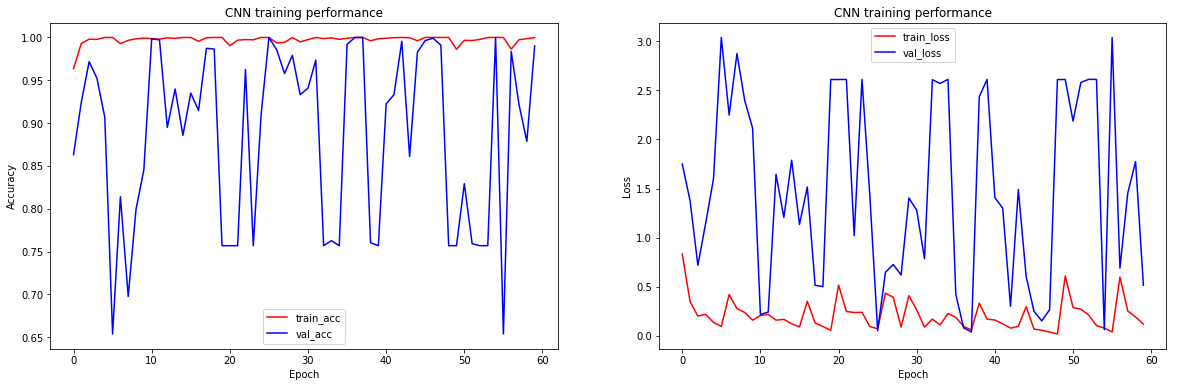

In [358]:
plot_cnn(cnn_gw_history)

**Network Exploration**

In [396]:
def plot_saliency_gw(img_idx=None, x_test=X_test, ytest=y_test, cnn=cnn_gw, labels=['ND', 'GW']):
    if img_idx == None:
        img_idx = randint(0, ytest.shape[0])
    input_image = x_test[img_idx]
    grads = visualize_cam(cnn_gw, -1, filter_indices=0, 
                               seed_input=input_image, backprop_modifier=None)
    predicted_label = labels[np.argmax(cnn.predict(x_test[img_idx].reshape(1,39,100,2)),1)[0]]
    fig, ax = plt.subplots(1,3, figsize=(10,5))
    ax[0].imshow(input_image[:,:,0])
    ax[0].set_title('original img id {} - {} - H1'.format(img_idx, labels[ytest[img_idx][0].astype('int')]))
    ax[1].imshow(input_image[:,:,1])
    ax[1].set_title('original img id {} - {} - L1'.format(img_idx, labels[ytest[img_idx][0].astype('int')]))
    ax[2].imshow(grads, cmap='jet')
    ax[2].set_title('saliency - predicted {}'.format(predicted_label))
    print('Event ID {}'.format(img_idx))

The plot below shows areas of the spectogram which were most relevant for classifying the event as a non-gravitational wave. 

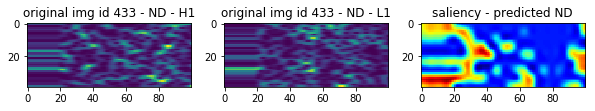

In [375]:
plot_saliency_gw()

The plot belows shows an annomaly in our network in the case of false negative. The model missed a gravitational wave. This suggests that the model might not be powerful enough. 

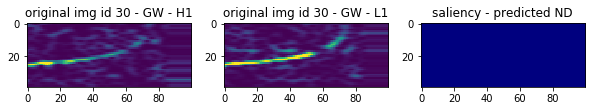

In [380]:
plot_saliency_gw()

Event ID 8


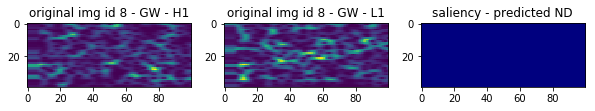

In [405]:
plot_saliency_gw()